### Classes

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import json
import os
import matplotlib.colors as mcolors
import random
from scipy.interpolate import CubicSpline
import torch
import pandas as pd

In [2]:
class Player():
    all_videos = []
    body_parts_names = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]
    colors = ['#00FFFF', '#7FFFD4', '#000000', '#0000FF', '#8A2BE2', '#A52A2A', '#DEB887', '#5F9EA0', '#7FFF00', '#D2691E', '#FF7F50', '#6495ED', '#DC143C', '#00FFFF']
    
    def __init__(self, player_name):
        self.name = player_name
        self.videos = []
        
    def add_video(self, video):
        self.videos.append(video)
        Player.all_videos.append(video)
        
        if Video.should_transform == False:
            Video.should_transform = True  

In [3]:
class Video():
    should_transform = False
    num_frames = 26
    hitting_frame_id = 15
    start_frame_id = 5
    end_frame_id = 20
    
    initial_joints = [None for _ in range(num_frames)]
    initial_extremities = [None for _ in range(num_frames)]
    initial_aprox_joint = {}
    initial_spline_before_length = {}
    initial_spline_after_length = {}
    
    def __init__(self):
        self.frames = []
        self.c = 1.0
        self.right_wrist_difference = 0.0
        self.joints_positions = {}
        self.cubic_splines = {}
        self.cubic_splines_normalized = {}
        self.min_t = {}
        self.max_t = {}
        
    def add_frame(self, frame):
        self.frames.append(frame)
        
    def calculate_joints_positions(self):
        for frame in self.frames:
            for joint_name in frame.joints.keys():
                joint_frame_position = frame.joints[joint_name]
                if joint_name not in self.joints_positions.keys():
                    self.joints_positions[joint_name] = []
                self.joints_positions[joint_name].append(joint_frame_position)
    
    def calculate_spline_length(self, f, min_t, max_t):
        t_new = np.linspace(min_t, max_t, 1000)
        p_new = f(t_new)
        
        curve_len = 0.0
        for i in range(len(t_new)-1):
            curve_len += np.linalg.norm(p_new[i+1] - p_new[i])
        
        return curve_len
    
    def correct_min_t(self, f, initial_curve_len, min_t, max_t):
        t_new = np.linspace(max_t, min_t, 1000)
        p_new = f(t_new)
        
        curve_len = 0.0
        for i in range(len(t_new)-1):
            curve_len += np.linalg.norm(p_new[i+1] - p_new[i])
            if curve_len > initial_curve_len:
                return (t_new[i+1] + t_new[i]) / 2.0
        return min_t
        
    def correct_max_t(self, f, initial_curve_len, min_t, max_t):
        t_new = np.linspace(min_t, max_t, 1000)
        p_new = f(t_new)
        
        curve_len = 0.0
        for i in range(len(t_new)-1):
            curve_len += np.linalg.norm(p_new[i+1] - p_new[i])
            if curve_len > initial_curve_len:
                return (t_new[i+1] + t_new[i]) / 2.0
        return max_t
                
    def calculate_cubic_spline_interpolation(self):
        for joint_name in self.joints_positions.keys():
            p_with_outliers = self.joints_positions[joint_name]
            p = [p_with_outliers[0]]
            outliers_pos = []
        
            for i in range(len(p_with_outliers)-2):
                v1 = p_with_outliers[i+1] - p_with_outliers[i]
                v2 = p_with_outliers[i+2] - p_with_outliers[i]
                n = np.cross(v1, v2)
                orientation = n[2]

                if orientation > 0:
                    p.append(p_with_outliers[i+1].copy())
                else:
                    outliers_pos.append(i+1) 

            p.append(p_with_outliers[i+2].copy())
            t = [i for i in range(Video.num_frames) if i not in outliers_pos]
            f = CubicSpline(t, p, bc_type='natural')
            self.cubic_splines[joint_name] = f
            
            if Video.should_transform == False:
                Video.initial_aprox_joint[joint_name] = f(Video.hitting_frame_id)
                Video.initial_spline_before_length[joint_name] = self.calculate_spline_length(f, Video.start_frame_id, Video.hitting_frame_id)
                Video.initial_spline_after_length[joint_name] = self.calculate_spline_length(f, Video.hitting_frame_id, Video.end_frame_id)
                
                self.min_t[joint_name] = Video.start_frame_id
                self.max_t[joint_name] = Video.end_frame_id
                t_normalized = np.linspace(self.min_t[joint_name], self.max_t[joint_name], Video.end_frame_id-Video.start_frame_id+1)
                p_normalized = f(t_normalized)
                f_normalized = CubicSpline(t_normalized, p_normalized, bc_type='natural')
                self.cubic_splines_normalized[joint_name] = f_normalized

            else:
                self.min_t[joint_name] = self.correct_min_t(f, Video.initial_spline_before_length[joint_name], 0, Video.hitting_frame_id)
                self.max_t[joint_name] = self.correct_max_t(f, Video.initial_spline_after_length[joint_name], Video.hitting_frame_id, Video.num_frames-1)
                t_normalized = np.linspace(self.min_t[joint_name], self.max_t[joint_name], Video.end_frame_id-Video.start_frame_id+1)
                spline_aprox_joint = f(Video.hitting_frame_id)
                initial_joint = Video.initial_aprox_joint[joint_name]
                
                diff = np.array([initial_joint[0] - spline_aprox_joint[0], initial_joint[1] - spline_aprox_joint[1], 0.0])
                p_normalized = [(dot+diff) for dot in f(t_normalized)]
                f_normalized = CubicSpline(t_normalized, p_normalized, bc_type='natural')
                self.cubic_splines_normalized[joint_name] = f_normalized
                
    def plot_spline(self, ax, color, joint_name, player_name, normalized_spline):
        if normalized_spline == False:
            f = self.cubic_splines[joint_name]
            x = [x[0] for x in self.joints_positions[joint_name]]
            y = [x[1] for x in self.joints_positions[joint_name]]
            ax.scatter(x, y, s=10, color='black')
            
        else:
            f = self.cubic_splines_normalized[joint_name]
           
        t_new = np.linspace(min(f.x), max(f.x), 1000)
        p_new = f(t_new)
        xs = [dot[0] for dot in p_new]
        ys = [dot[1] for dot in p_new]
        ax.plot(xs, ys, color=color, label=player_name)
             
    def plot_joint(self, ax, color, joint_name, player_name):
        x_coords = [x[0] for x in self.joints_positions[joint_name]]
        y_coords = [x[1] for x in self.joints_positions[joint_name]]

        ax.scatter(x_coords, y_coords, s=10, color='black')
        ax.plot(x_coords, y_coords, color=color, label=player_name)

In [4]:
class Frame():
    def __init__(self, frame_id):
        self.id = frame_id
        self.joints = {}
        self.extremities = {}
        
    def calculate_shoulder_width(self, shoulder_strap):
        shoulder_width = shoulder_strap[0][1] - shoulder_strap[0][0]
        if shoulder_width == 0.0:
            shoulder_width = 1.0
        return shoulder_width
    
    def calculate_hip_width(self, left_hip, right_hip):
        hip_width = left_hip[0] - right_hip[0]
        if hip_width == 0.0:
            hip_width = 1.0
        return hip_width
    
    def calculate_cx(self, cx_shoulders, cx_hips):
        cx_candidates = [abs(1.0 - cx_shoulders), abs(1.0 - cx_hips)]
        return cx_shoulders if np.argmin(cx_candidates) == 0 else cx_hips
    
    def calculate_longer_leg_length(self, joints):
        left_leg_length = joints['left_knee'][1] - joints['left_ankle'][1]
        right_leg_length = joints['right_knee'][1] - joints['right_ankle'][1]
        return max(left_leg_length, right_leg_length)
    
    def calculate_scaling_center(self):
        joints_x_positions = [x[0] for x in self.joints.values()]
        joints_y_positions = [x[1] for x in self.joints.values()]
        
        left_outer_coord = joints_x_positions[np.argmin(joints_x_positions)]
        right_outer_coord = joints_x_positions[np.argmax(joints_x_positions)]
        bottom_outer_coord = joints_y_positions[np.argmin(joints_y_positions)]
        top_outer_coord = joints_y_positions[np.argmax(joints_y_positions)]
        
        scaling_center = [right_outer_coord - left_outer_coord, top_outer_coord - bottom_outer_coord]
        return scaling_center
    
    def calculate_scaling_matrix(self, scaling_center, cx, cy):
        first_tran_matrix = np.array([[1.0, 0.0, -scaling_center[0]],
                                      [0.0, 1.0, -scaling_center[1]],
                                      [0.0, 0.0, 1.0]])
        
        zero_scaling_matrix = np.array([[cx, 0.0, 0.0],
                                       [0.0, cy, 0.0],
                                       [0.0, 0.0, 1.0]])
        
        last_tran_matrix = np.array([[1.0, 0.0, scaling_center[0]],
                                     [0.0, 1.0, scaling_center[1]],
                                     [0.0, 0.0, 1.0]])
        
        return last_tran_matrix @ zero_scaling_matrix @ first_tran_matrix
    
    def set_initial_joints(self):
        if Video.should_transform == False:
            Video.initial_joints[self.id] = self.joints
            
    def set_initial_extremities(self):
        if Video.should_transform == False:
            Video.initial_extremities[self.id] = self.extremities
        
    def calculate_c(self, video):
        cx_shoulders = abs(self.calculate_shoulder_width(Video.initial_extremities[self.id]['shoulder_strap']) / self.calculate_shoulder_width(self.extremities['shoulder_strap']))
        cx_hips = abs(self.calculate_hip_width(Video.initial_joints[self.id]['left_hip'], Video.initial_joints[self.id]['right_hip']) / self.calculate_hip_width(self.joints['left_hip'], self.joints['right_hip']))
        cx = self.calculate_cx(cx_shoulders, cx_hips)

        cy = self.calculate_longer_leg_length(Video.initial_joints[self.id]) / self.calculate_longer_leg_length(self.joints)
        c_candidates = [abs(1.0 - cx), abs(1.0 - cy)]
        video.c = cx if np.argmin(c_candidates) == 0 else cy    
        
    def scale(self, video):
        scaling_center = self.calculate_scaling_center()
        scaling_matrix = self.calculate_scaling_matrix(scaling_center, video.c, video.c)
        
        for joint_name in self.joints.keys():
            self.joints[joint_name] = scaling_matrix @ self.joints[joint_name]
        self.set_shoulder_middle_position(self.joints['left_shoulder'], self.joints['right_shoulder'])
        self.update_extremities()
        
    def calculate_right_wrist_difference(self, video):
        right_wrist = self.joints['right_wrist']
        initial_right_wrist = Video.initial_joints[self.id]['right_wrist']
        video.right_wrist_difference = [initial_right_wrist[0] - right_wrist[0], initial_right_wrist[1] - right_wrist[1]]  
        
    def translate(self, video):
        for joint_name in self.joints.keys():
            self.joints[joint_name] = np.array([
                self.joints[joint_name][0] + video.right_wrist_difference[0],
                self.joints[joint_name][1] + video.right_wrist_difference[1],
                1.0
            ])

        self.set_shoulder_middle_position(self.joints['left_shoulder'], self.joints['right_shoulder'])
        self.update_extremities()
        
    def plot_frame(self, ax, color, label):
        ax.set_xlim(0, 1280)
        ax.set_ylim(-100, 720)
        
        x_coords = [x[0] for x in self.joints.values()]
        y_coords = [x[1] for x in self.joints.values()]
        ax.scatter(x_coords, y_coords, s=10, color='black')
        
        ax.plot(self.extremities['bottom_right_leg'][0], self.extremities['bottom_right_leg'][1], color = color)
        ax.plot(self.extremities['bottom_left_leg'][0], self.extremities['bottom_left_leg'][1], color = color)
        ax.plot(self.extremities['top_right_leg'][0], self.extremities['top_right_leg'][1], color = color)
        ax.plot(self.extremities['top_left_leg'][0], self.extremities['top_left_leg'][1], color = color)
        ax.plot(self.extremities['right_body_line'][0], self.extremities['right_body_line'][1], color = color)
        ax.plot(self.extremities['left_body_line'][0], self.extremities['left_body_line'][1], color = color)
        ax.plot(self.extremities['shoulder_strap'][0], self.extremities['shoulder_strap'][1], color = color)
        ax.plot(self.extremities['bottom_right_arm'][0], self.extremities['bottom_right_arm'][1], color = color)
        ax.plot(self.extremities['bottom_left_arm'][0], self.extremities['bottom_left_arm'][1], color = color)
        ax.plot(self.extremities['top_right_arm'][0], self.extremities['top_right_arm'][1], color = color)
        ax.plot(self.extremities['top_left_arm'][0], self.extremities['top_left_arm'][1], color = color)
        ax.plot(self.extremities['right_ear_eye'][0], self.extremities['right_ear_eye'][1], color = color)
        ax.plot(self.extremities['left_ear_eye'][0], self.extremities['left_ear_eye'][1], color = color)
        ax.plot(self.extremities['right_eye_nose'][0], self.extremities['right_eye_nose'][1], color = color)
        ax.plot(self.extremities['left_eye_nose'][0], self.extremities['left_eye_nose'][1], color = color, label=label)

    def add_joint(self, joint):
        self.joints[joint.name] = joint.coord
        
    def set_shoulder_middle_position(self, left_shoulder, right_shoulder):
        self.shoulder_middle_position = [(right_shoulder[0] + left_shoulder[0]) / 2, (right_shoulder[1] + left_shoulder[1]) / 2]

    def update_extremities(self):
        self.extremities['bottom_right_leg'] = [[self.joints['right_knee'][0], self.joints['right_ankle'][0]], [self.joints['right_knee'][1], self.joints['right_ankle'][1]]]
        self.extremities['bottom_left_leg'] = [[self.joints['left_knee'][0], self.joints['left_ankle'][0]], [self.joints['left_knee'][1], self.joints['left_ankle'][1]]]
        self.extremities['top_right_leg'] = [[self.joints['right_hip'][0], self.joints['right_knee'][0]], [self.joints['right_hip'][1], self.joints['right_knee'][1]]]
        self.extremities['top_left_leg'] = [[self.joints['left_hip'][0], self.joints['left_knee'][0]], [self.joints['left_hip'][1], self.joints['left_knee'][1]]]
        self.extremities['right_body_line'] = [[self.shoulder_middle_position[0], self.joints['right_hip'][0]], [self.shoulder_middle_position[1], self.joints['right_hip'][1]]]
        self.extremities['left_body_line'] = [[self.shoulder_middle_position[0], self.joints['left_hip'][0]], [self.shoulder_middle_position[1], self.joints['left_hip'][1]]]
        self.extremities['shoulder_strap'] = [[self.joints['left_shoulder'][0], self.joints['right_shoulder'][0]], [self.joints['left_shoulder'][1], self.joints['right_shoulder'][1]]]
        self.extremities['bottom_right_arm'] = [[self.joints['right_wrist'][0], self.joints['right_elbow'][0]], [self.joints['right_wrist'][1], self.joints['right_elbow'][1]]]
        self.extremities['bottom_left_arm'] = [[self.joints['left_wrist'][0], self.joints['left_elbow'][0]], [self.joints['left_wrist'][1], self.joints['left_elbow'][1]]]
        self.extremities['top_right_arm'] = [[self.joints['right_shoulder'][0], self.joints['right_elbow'][0]], [self.joints['right_shoulder'][1], self.joints['right_elbow'][1]]]
        self.extremities['top_left_arm'] = [[self.joints['left_shoulder'][0], self.joints['left_elbow'][0]], [self.joints['left_shoulder'][1], self.joints['left_elbow'][1]]]
        self.extremities['right_ear_eye'] = [[self.joints['right_ear'][0], self.joints['right_eye'][0]], [self.joints['right_ear'][1], self.joints['right_eye'][1]]]
        self.extremities['left_ear_eye'] = [[self.joints['left_ear'][0], self.joints['left_eye'][0]], [self.joints['left_ear'][1], self.joints['left_eye'][1]]]
        self.extremities['right_eye_nose'] = [[self.joints['right_eye'][0], self.joints['nose'][0]], [self.joints['right_eye'][1], self.joints['nose'][1]]]
        self.extremities['left_eye_nose'] = [[self.joints['left_eye'][0], self.joints['nose'][0]], [self.joints['left_eye'][1], self.joints['nose'][1]]]
        
    def set_extremities(self):
        self.extremities['bottom_right_leg'] = Extremity(
            'bottom_right_leg', 
            [self.joints['right_knee'][0], self.joints['right_ankle'][0]], 
            [self.joints['right_knee'][1], self.joints['right_ankle'][1]]
        ).get_vector()
        self.extremities['bottom_left_leg'] = Extremity(
            'bottom_left_leg', 
            [self.joints['left_knee'][0], self.joints['left_ankle'][0]], 
            [self.joints['left_knee'][1], self.joints['left_ankle'][1]]
        ).get_vector()
        self.extremities['top_right_leg'] = Extremity(
            'top_right_leg', 
            [self.joints['right_hip'][0], self.joints['right_knee'][0]], 
            [self.joints['right_hip'][1], self.joints['right_knee'][1]]
        ).get_vector()
        self.extremities['top_left_leg'] = Extremity(
            'top_left_leg', 
            [self.joints['left_hip'][0], self.joints['left_knee'][0]], 
            [self.joints['left_hip'][1], self.joints['left_knee'][1]]
        ).get_vector()
        self.extremities['right_body_line'] = Extremity(
            'right_body_line', 
            [self.shoulder_middle_position[0], self.joints['right_hip'][0]], 
            [self.shoulder_middle_position[1], self.joints['right_hip'][1]]
        ).get_vector()
        self.extremities['left_body_line'] = Extremity(
            'left_body_line', 
            [self.shoulder_middle_position[0], self.joints['left_hip'][0]], 
            [self.shoulder_middle_position[1], self.joints['left_hip'][1]]
        ).get_vector()
        self.extremities['shoulder_strap'] = Extremity(
            'shoulder_strap', 
            [self.joints['left_shoulder'][0], self.joints['right_shoulder'][0]], 
            [self.joints['left_shoulder'][1], self.joints['right_shoulder'][1]]
        ).get_vector()
        self.extremities['bottom_right_arm'] = Extremity(
            'bottom_right_arm', 
            [self.joints['right_wrist'][0], self.joints['right_elbow'][0]], 
            [self.joints['right_wrist'][1], self.joints['right_elbow'][1]]
        ).get_vector()
        self.extremities['bottom_left_arm'] = Extremity(
            'bottom_left_arm', 
            [self.joints['left_wrist'][0], self.joints['left_elbow'][0]], 
            [self.joints['left_wrist'][1], self.joints['left_elbow'][1]]
        ).get_vector()
        self.extremities['top_right_arm'] = Extremity(
            'top_right_arm', 
            [self.joints['right_shoulder'][0], self.joints['right_elbow'][0]], 
            [self.joints['right_shoulder'][1], self.joints['right_elbow'][1]]
        ).get_vector()
        self.extremities['top_left_arm'] = Extremity(
            'top_left_arm', 
            [self.joints['left_shoulder'][0], self.joints['left_elbow'][0]], 
            [self.joints['left_shoulder'][1], self.joints['left_elbow'][1]]
        ).get_vector()
        self.extremities['right_ear_eye'] = Extremity(
            'right_ear_eye', 
            [self.joints['right_ear'][0], self.joints['right_eye'][0]], 
            [self.joints['right_ear'][1], self.joints['right_eye'][1]]
        ).get_vector()
        self.extremities['left_ear_eye'] = Extremity(
            'left_ear_eye', 
            [self.joints['left_ear'][0], self.joints['left_eye'][0]], 
            [self.joints['left_ear'][1], self.joints['left_eye'][1]]
        ).get_vector()
        self.extremities['right_eye_nose'] = Extremity(
            'right_eye_nose', 
            [self.joints['right_eye'][0], self.joints['nose'][0]], 
            [self.joints['right_eye'][1], self.joints['nose'][1]]
        ).get_vector()
        self.extremities['left_eye_nose'] = Extremity(
            'left_eye_nose', 
            [self.joints['left_eye'][0], self.joints['nose'][0]], 
            [self.joints['left_eye'][1], self.joints['nose'][1]]
        ).get_vector()


In [5]:
class Joint():
    def __init__(self, joint_name, coord):
        self.name = joint_name
        self.coord = np.array(coord)

In [6]:
class Extremity():
    def __init__(self, extremity_name, x_coords, y_coords):
        self.name = extremity_name
        self.x_coords = np.array(x_coords)
        self.y_coords = np.array(y_coords)
        
    def get_vector(self):
        return [self.x_coords, self.y_coords]

In [7]:
dimitrov_poses_path = r'C:\Users\mihai\Desktop\forehand-analysis\dimitrov\dimitrov_poses'
sinner_poses_path = r'C:\Users\mihai\Desktop\forehand-analysis\sinner\sinner_poses'
#djokovic_poses_path = r'C:\Users\mihai\Desktop\forehand-analysis\djokovic\djokovic_poses'

poses_paths = [dimitrov_poses_path, sinner_poses_path]

In [8]:
players = []
for player_all_poses_path in poses_paths:
    player_name = player_all_poses_path.split('\\')[-2]
    player = Player(player_name)
    players.append(player)
    
    for path in os.listdir(player_all_poses_path):
        player_poses_path = os.path.join(player_all_poses_path, path, 'alphapose-results.json')
        video = Video()
        
        with open(player_poses_path, "r", encoding="UTF-8") as file:
            player_poses_dict = json.load(file)
        
        images = {}
        for player_pose in player_poses_dict:
            image_id = player_pose['image_id']
            if image_id not in images.keys():
                images[image_id] = []
            images[image_id].append(player_pose)
        
        index = 0
        for image_id in images.keys():
            player_pose = max(images[image_id], key= lambda x: x['keypoints'][43])
            frame = Frame(index)
            video.add_frame(frame)

            joints_x_positions = [player_pose['keypoints'][i] for i in range(len(player_pose['keypoints'])) if i%3==0]
            joints_y_positions = [720 - player_pose['keypoints'][i] for i in range(len(player_pose['keypoints'])) if i%3==1]

            body_parts_coords = [(x, y, 1.0) for x, y in zip(joints_x_positions, joints_y_positions)]
            for i, body_part in enumerate(Player.body_parts_names):
                joint = Joint(body_part, body_parts_coords[i])
                frame.add_joint(joint)

            frame.set_shoulder_middle_position(frame.joints['left_shoulder'], frame.joints['right_shoulder'])
            frame.set_extremities()
                
            index = index+1
            
            if Video.should_transform == False:
                frame.set_initial_joints()
                frame.set_initial_extremities()
        
        if Video.should_transform == True:
            video.frames[Video.hitting_frame_id].calculate_c(video)
            for frame in video.frames:
                frame.scale(video)
            
            video.frames[Video.hitting_frame_id].calculate_right_wrist_difference(video)
            for frame in video.frames:
                frame.translate(video)
                
        
        video.calculate_joints_positions()
        video.calculate_cubic_spline_interpolation()
        player.add_video(video)

In [9]:
len(Player.all_videos)

20

In [10]:
#css4_colors = mcolors.CSS4_COLORS
#colors = list(css4_colors.values())
#css4_colors

### Players from videos normalized compared

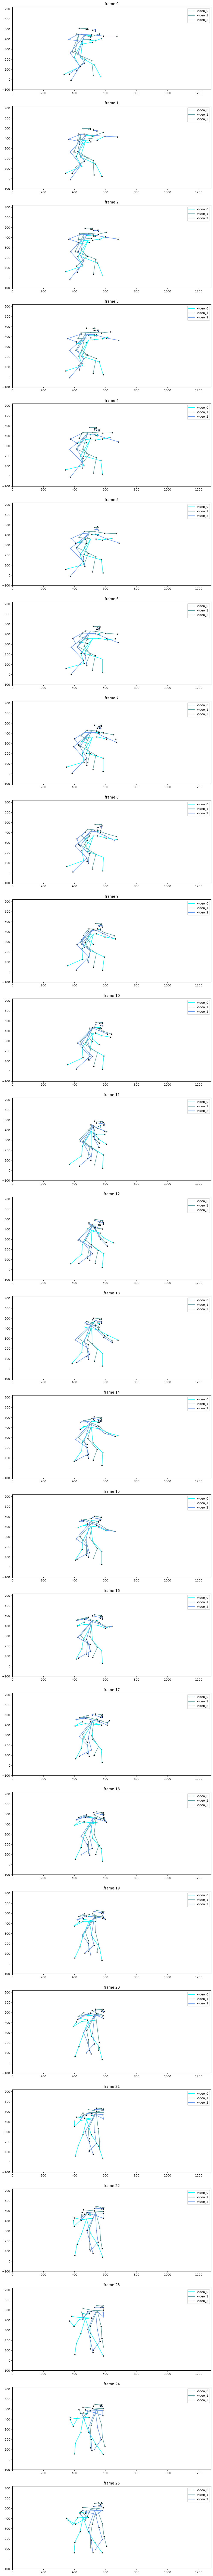

In [13]:
fig, axs = plt.subplots(Video.num_frames, 1, figsize=(12, 156))
for i, video in enumerate(Player.all_videos[0:3]):
    color = Player.colors[random.randrange(len(Player.colors))]
    label = f'video_{i}'
    
    for i, frame in enumerate(video.frames):
        ax = axs[i]
        ax.set_title(f'frame {i}')
        frame.plot_frame(ax, color, label)
        
for i, ax in enumerate(axs):
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    ax.legend(ax_handles, ax_labels)

### Player's joint linear vs spline path

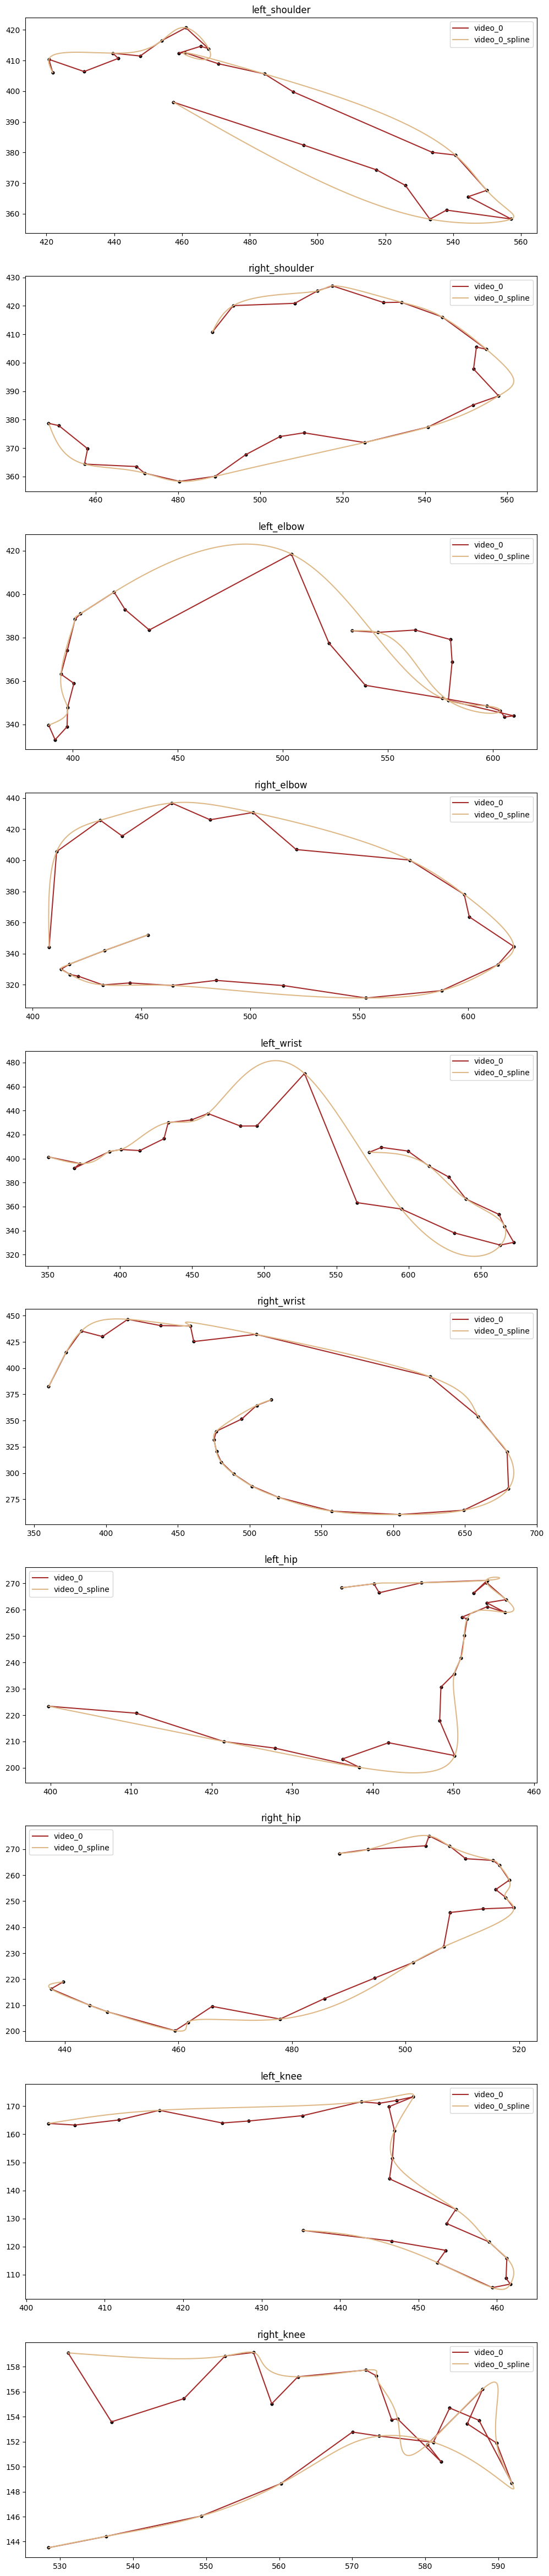

In [14]:
fig1, axs1 = plt.subplots(10, 1, figsize=(12, 60))

for i, video in enumerate(Player.all_videos[0:1]):
    color = Player.colors[random.randrange(len(Player.colors))]
    label = f'video_{i}'
    
    spline_color = Player.colors[random.randrange(len(Player.colors))]
    spline_label = f'video_{i}_spline'
    
    for j, joint_name in enumerate(list(video.joints_positions.keys())[5:15]):
        ax = axs1[j]
        ax.set_title(f'{joint_name}')
        video.plot_joint(ax, color, joint_name, label)
        video.plot_spline(ax, spline_color, joint_name, spline_label, False)

for i, ax in enumerate(axs1):
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    ax.legend(ax_handles, ax_labels)

### Players from videos spline paths compared

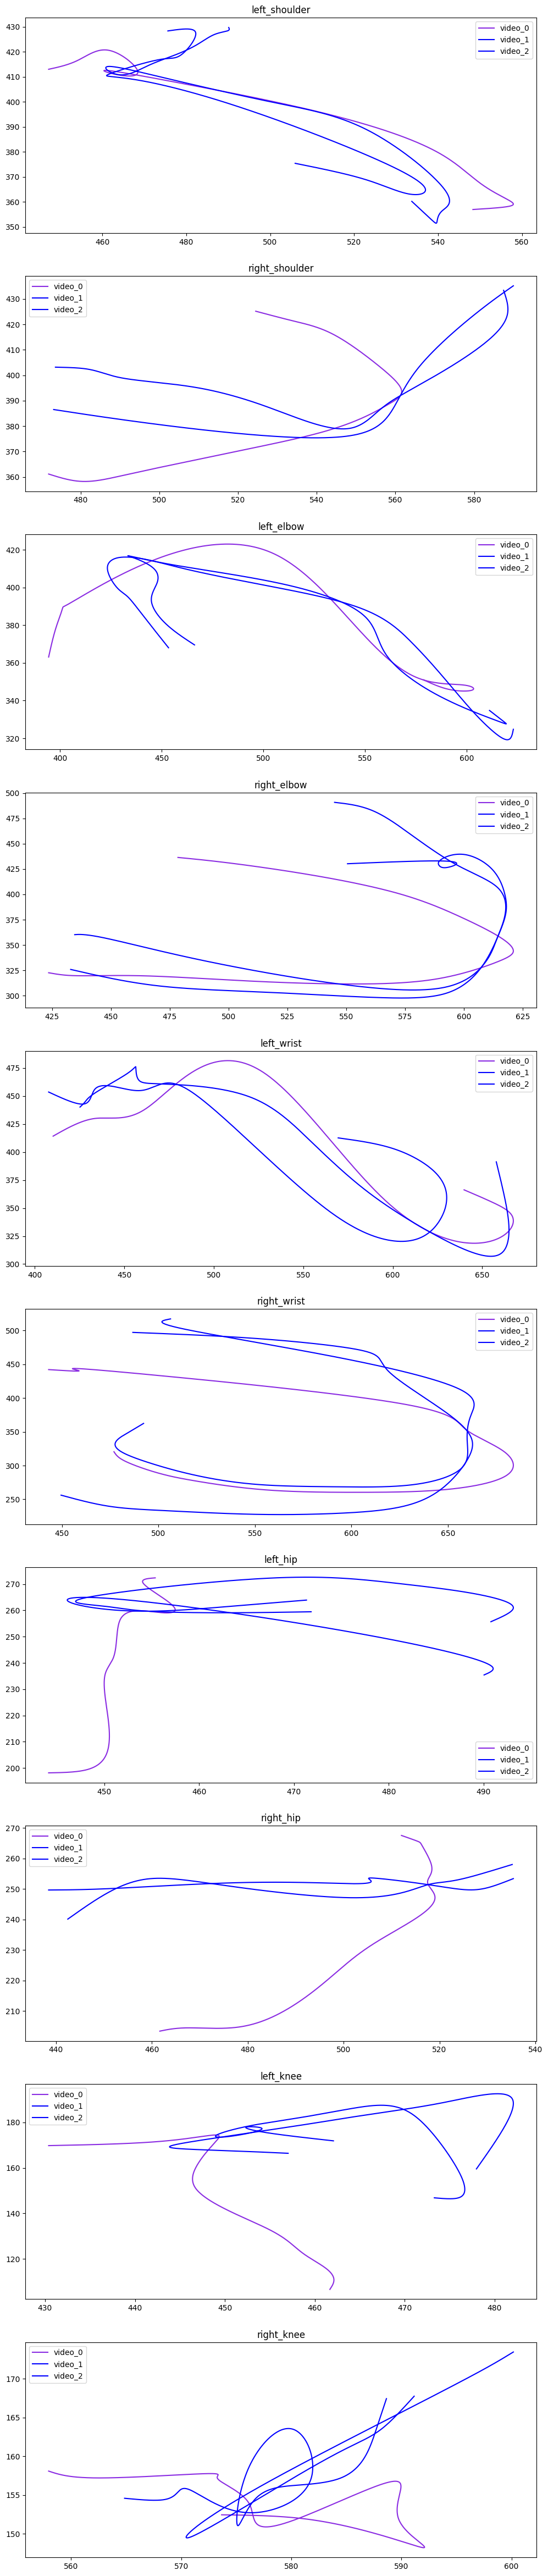

In [15]:
fig2, axs2 = plt.subplots(10, 1, figsize=(12, 60))

for i, video in enumerate(Player.all_videos[0:3]):
    color = Player.colors[random.randrange(len(Player.colors))]
    label = f'video_{i}'
    
    for j, joint_name in enumerate(list(video.joints_positions.keys())[5:15]):
        ax = axs2[j]
        ax.set_title(f'{joint_name}')
        player_name = label
        video.plot_spline(ax, color, joint_name, player_name, True)

for i, ax in enumerate(axs2):
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    ax.legend(ax_handles, ax_labels)

### Videos

In [16]:
len(Player.all_videos)

20

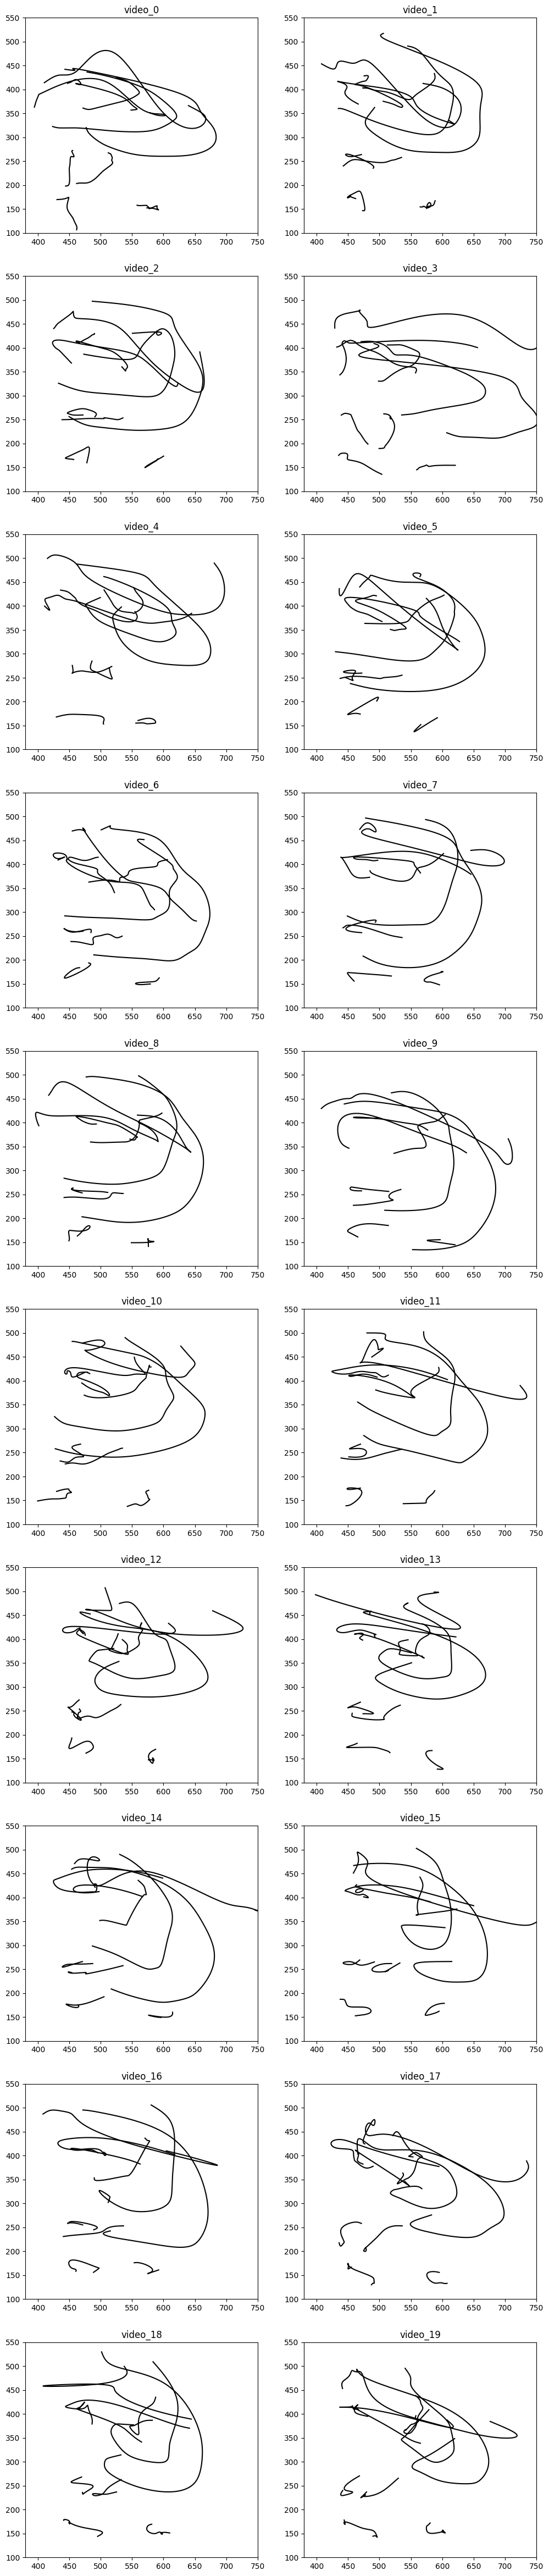

In [18]:
fig3, axs3 = plt.subplots(10, 2, figsize=(12, 60))

for i, video in enumerate(Player.all_videos):
    color = 'black'
    label = f'video_{i}'
    ax = axs3[i//2][i%2]
    ax.set_title(f'{label}')
    ax.set_xlim(380, 750)
    ax.set_ylim(100, 550)
    
    for j, joint_name in enumerate(list(video.joints_positions.keys())[5:15]):
        video.plot_spline(ax, color, joint_name, label, True)
        
    extent = ax.get_window_extent().transformed(fig3.dpi_scale_trans.inverted())
    fig3.savefig(f'images_dataset/ax{i}_figure.png', bbox_inches=extent)

### Spline comparison

In [19]:
from scipy.integrate import simpson
from scipy.integrate import quad
from scipy.integrate import trapezoid

In [20]:
def t(x, domen_diff, codomen_diff, domen_min, codomen_min):
    return codomen_diff/domen_diff*(x-domen_min)+codomen_min

In [21]:
joint_name = 'right_knee'
num_points = 100

initial_min_t = players[0].videos[0].min_t[joint_name]
initial_max_t = players[0].videos[0].max_t[joint_name]
dimitrov_min_t = players[0].videos[1].min_t[joint_name]
dimitrov_max_t = players[0].videos[1].max_t[joint_name]
sinner_min_t = players[1].videos[0].min_t[joint_name]
sinner_max_t = players[1].videos[0].max_t[joint_name]

initial_points = np.linspace(initial_min_t, initial_max_t, num_points)
dimitrov_points = np.linspace(dimitrov_min_t, dimitrov_max_t, num_points)
sinner_points = np.linspace(sinner_min_t, sinner_max_t, num_points)

initial_diff = Video.end_frame_id-Video.start_frame_id
dimitrov_diff = dimitrov_max_t - dimitrov_min_t
sinner_diff = sinner_max_t - sinner_min_t

f = players[0].videos[0].cubic_splines_normalized[joint_name]
g1 = players[0].videos[1].cubic_splines_normalized[joint_name]
g2 = players[1].videos[0].cubic_splines_normalized[joint_name]

integral_min_t = -0.5
integral_max_t = 0.5
integral_diff = integral_max_t-integral_min_t

spline_x_min_t = 380
spline_x_max_t = 700
spline_x_diff = spline_x_max_t-spline_x_min_t

spline_y_min_t = 80
spline_y_max_t = 50
spline_y_diff = spline_y_max_t-spline_y_min_t

x=initial_points

f_wn = f(x)
first_coord_f = np.array([coord[0] for coord in f_wn])
second_coord_f = np.array([coord[1] for coord in f_wn])

f1 = t(first_coord_f, spline_x_diff, integral_diff, spline_x_min_t, integral_min_t)
f2 = t(second_coord_f, spline_y_diff, integral_diff, spline_y_min_t, integral_min_t)
F = [np.array([x, y]) for x, y in zip(f1, f2)]
vectors_f = [np.array([f1[i+1]-f1[i], f2[i+1]-f2[i]]) for i in range(num_points-1)]

g1_wn = g1(t(x, initial_diff, dimitrov_diff, initial_min_t, dimitrov_min_t))
first_coord_g1 = np.array([coord[0] for coord in g1_wn])
second_coord_g1 = np.array([coord[1] for coord in g1_wn])
g11 = t(first_coord_g1, spline_x_diff, integral_diff, spline_x_min_t, integral_min_t)
g12 = t(second_coord_g1, spline_y_diff, integral_diff, spline_y_min_t, integral_min_t)
G1 = [np.array([x, y]) for (x, y) in zip(g11, g12)]
vectors_g1 = [np.array([g11[i+1]-g11[i], g12[i+1]-g12[i+1]]) for i in range(num_points-1)]

g2_wn = g2(t(x, initial_diff, sinner_diff, initial_min_t, sinner_min_t))
first_coord_g2 = np.array([coord[0] for coord in g2_wn])
second_coord_g2 = np.array([coord[1] for coord in g2_wn])
g21 = t(first_coord_g2, spline_x_diff, integral_diff, spline_x_min_t, integral_min_t)
g22 = t(second_coord_g2, spline_y_diff, integral_diff, spline_y_min_t, integral_min_t)
G2 = [np.array([x, y]) for (x, y) in zip(g21, g22)]
vectors_g2 = [np.array([g21[i+1]-g21[i], g22[i+1]-g22[i+1]]) for i in range(num_points-1)]

res1 = []
res2 = []
sum1 = 0.0
sum2 = 0.0
sqrt_2 = np.sqrt(2)

for i in range(len(x)-1):
    cos1 = np.dot(vectors_f[i], vectors_g1[i]) / (np.linalg.norm(vectors_f[i])*np.linalg.norm(vectors_g1[i]))
    distance1 = sqrt_2-np.linalg.norm(F[i]-G1[i])
    temp1 = cos1*distance1
    res1.append(temp1)
    sum1 += temp1
    print(i, ' : ', sum1, ' : ', temp1, ' : ', cos1, ' : ', distance1)
    
    cos2 = np.dot(vectors_f[i], vectors_g2[i]) / (np.linalg.norm(vectors_f[i])*np.linalg.norm(vectors_g2[i]))
    distance2 = sqrt_2-np.linalg.norm(F[i]-G2[i])
    temp2 = cos2*distance2
    res2.append(cos2*distance2)
    sum2 += temp2
    print(i, ' : ', sum2, ' : ', temp2, ' : ', cos2, ' : ', distance2)
    print()
print(sum(res1))
print(sum(res2))

0  :  1.3068444236074963  :  1.3068444236074963  :  0.9766389132860664  :  1.3381039868771947
0  :  0.8892006148331191  :  0.8892006148331191  :  0.9766389132860666  :  0.9104701878417413

1  :  2.5935338702570934  :  1.286689446649597  :  0.9607131606657483  :  1.3393065686306993
1  :  1.7788073557863133  :  0.8896067409531943  :  0.9607131606657483  :  0.925985796152434

2  :  3.8254976289793197  :  1.231963758722226  :  0.9193985118559528  :  1.3399671011380152
2  :  2.6445715590874244  :  0.8657642033011108  :  0.9193985118559528  :  0.9416636987517278

3  :  4.95423991743659  :  1.1287422884572706  :  0.8425781039316012  :  1.3396292678273773
3  :  3.451498189019009  :  0.8069266299315845  :  0.842578103931601  :  0.9576876329521724

4  :  5.935464892506565  :  0.9812249750699747  :  0.7334325250090992  :  1.337853097062748
4  :  4.166036588026506  :  0.7145383990074972  :  0.7334325250090992  :  0.9742387672248819

5  :  6.750529397865491  :  0.8150645053589259  :  0.610901359227